In [120]:

import sys
import math
import numpy as np
import scipy
import matplotlib.pyplot as plt

sys.path.append('..')
from src.aaa_algorithms import aaa
from src.probability import Distribution
from src.spectral_transforms import psi_real_to_circle, psi_inv_circle_to_real, B_real, B_circle
from src.numerical import trap_quad, fourier_quad
from src.plotting import plot_real_distribution, plot_circle_distribution, plot_circle_distribution_3D
import mpl_toolkits.mplot3d.art3d as art3d

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=8)
plt.rcParams.update({
    'font.size': 8,
    'text.usetex': True,
    'text.latex.preamble': r"\usepackage{amsfonts}" + "\n" + r"\usepackage{amsmath}" + "\n" + r"\usepackage{amssymb}"
})

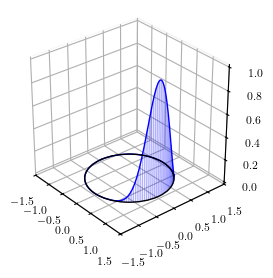

In [257]:
#density = lambda s: np.sqrt(s * (s >= 0))/np.pi
density = lambda s: np.exp(-20*s**2)
atoms = np.array([])
atom_wts = np.array([])
quad_pts, quad_wts = trap_quad(-1000, 1000, int(1e4))
#quad_pts = np.concatenate((np.flip(-np.logspace(-3, 3, int(1e4))), np.logspace(-3, 3, int(1e4))))
#quad_wts = np.arange(len(quad_pts))
lmbda = Distribution(density, atoms, atom_wts, quad_pts, quad_wts, full_support=True)
lmbda_circle, _ = psi_real_to_circle(lmbda, 0, 0, len(lmbda.quad_pts))

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(azim=-40, elev=30)
plot_circle_distribution_3D(ax, lmbda_circle, width = 1.5, color="blue", frac_fill=0.05)
ax.set_box_aspect((1, 1, 1))
plt.show()

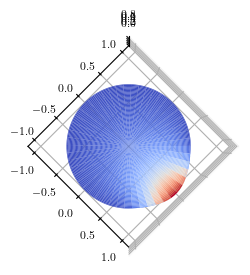

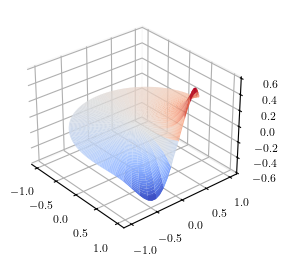

In [258]:
thetas = np.linspace(-np.pi, np.pi, 100)
rads = np.linspace(0, 1, 100)
Thetas, Rads = np.meshgrid(thetas, rads)
Zs = Rads*np.exp(1j*Thetas)
zs = np.reshape(Zs, -1)

def compute_Q(lmbda, zs):
    Q = np.zeros(len(zs), dtype=np.complex128)
    if lmbda.num_atoms > 0:
        inds = np.logical_and(np.isfinite(lmbda.atom_wts), lmbda.atom_wts != 0)
        Q += np.sum(lmbda.atom_wts[inds]*(1+np.exp(-1j*lmbda.atoms[inds])*zs[:, None])/(1-np.exp(-1j*lmbda.atoms[inds])*zs[:, None]), axis=1)
    if lmbda.density is not None:
        inds = np.logical_and(np.isfinite(lmbda.density_vals), lmbda.density_vals != 0)
        Q += np.sum(lmbda.quad_wts[inds]*lmbda.density_vals[inds]*(1 + np.exp(-1j*lmbda.quad_pts[inds])*zs[:, None])/(1 - np.exp(-1j*lmbda.quad_pts[inds])*zs[:, None]), axis=1) / (2*np.pi)
    return Q

Q = compute_Q(lmbda_circle, zs)
Q = np.reshape(Q, (len(rads), len(thetas)))

from matplotlib import cm

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(azim=-40, elev=90)
ax.plot_surface(np.real(Zs), np.imag(Zs), np.real(Q), cmap=cm.coolwarm)
plt.show()

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(azim=-40, elev=30)
ax.plot_surface(np.real(Zs), np.imag(Zs), np.imag(Q), cmap=cm.coolwarm)
plt.show()

In [259]:
np.linalg.norm(np.imag(Q - Q_AAA)) / np.linalg.norm(np.imag(Q))

ValueError: operands could not be broadcast together with shapes (100,100) (1000,1000) 

In [260]:
np.linalg.norm(np.real(Q - Q_AAA)) / np.linalg.norm(np.real(Q))

ValueError: operands could not be broadcast together with shapes (100,100) (1000,1000) 

In [261]:
def compute_Q_AAA(lmbda, aaa_iters=100):
    zs = np.exp(1j*lmbda.quad_pts)
    n = len(lmbda.quad_pts)

    pol, _, zer, _, _, _ = aaa(lmbda.density_vals, zs, max_terms=aaa_iters)

    out_circle = np.abs(pol) > 1

    num_pols = np.sum(out_circle)
    num_polys = len(zer) - len(pol)

    unit = np.ones((n, 1))
    poly = np.power(zs[:, None], np.arange(1, num_polys+1))
    rational = 1 / (zs[:, None] - pol[out_circle])

    A_orig = np.column_stack((unit, poly, rational))

    A_nrms = np.linalg.norm(A_orig, axis=0)
    A_orig_nrm = A_orig / A_nrms
    A = np.column_stack([np.real(A_orig_nrm), -np.imag(A_orig_nrm[:, 1:])])
    c = np.linalg.lstsq(A, lmbda.density_vals, rcond=1e-15)[0]
    c0 = c[0]
    c = np.reshape(c[1:], (-1, 2), order='F') @ np.array([1, 1j])
    c = np.insert(c, 0, c0)
    c /= A_nrms

    poly_inds = np.arange(1, num_polys+1)
    rational_inds = np.arange(num_polys+1, num_polys+num_pols+1)

    c_unit = c[0]
    c_poly = c[poly_inds]
    c_rational = c[rational_inds]
    
    sigma_int = np.imag(np.sum(c_poly*np.power(0, np.arange(1, num_polys+1))) - np.sum(c_rational / pol[out_circle]))

    Q = lambda z: c_unit*np.ones_like(z) - 1j*sigma_int + np.sum(c_poly*np.power(z[:, None], np.arange(1, num_polys+1)), axis=1) + np.sum(c_rational / (z[:, None] - pol[out_circle]), axis=1)
    return Q

Q_fun = compute_Q_AAA(lmbda_circle)

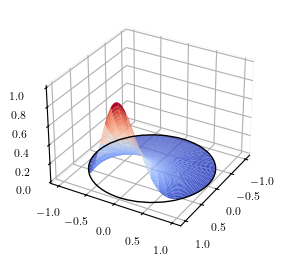

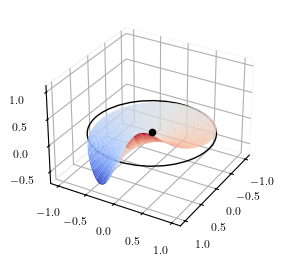

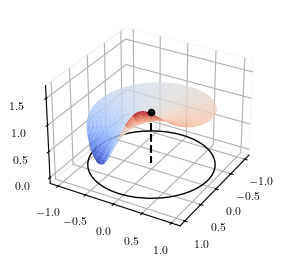

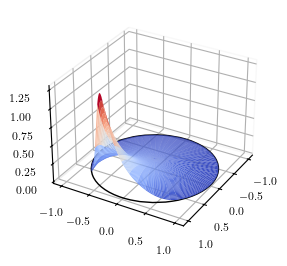

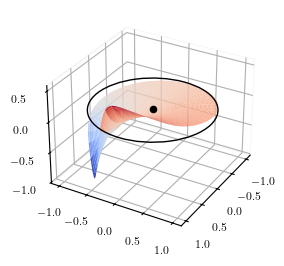

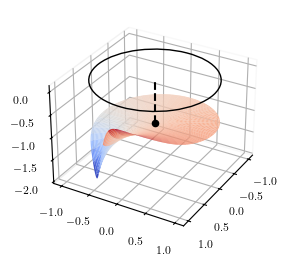

In [262]:
thetas = np.linspace(-np.pi, np.pi, 1000)
rads = np.linspace(0, 1, 1000)
Thetas, Rads = np.meshgrid(thetas, rads)
Zs = Rads*np.exp(1j*Thetas)
zs = np.reshape(Zs, -1)

Q_AAA = Q_fun(zs)
Q_AAA = np.reshape(Q_AAA, (len(rads), len(thetas)))

c0 = 1
mu_circle, zeta0 = B_circle(lmbda_circle, c0)

from matplotlib import cm

azim = 30
elev = 30

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(azim=azim, elev=elev)
ax.plot_surface(np.real(Zs), np.imag(Zs), np.real(Q_AAA), cmap=cm.coolwarm)
circle = plt.Circle((0, 0), 1, color='black', fill=False)
p = ax.add_patch(circle)
art3d.pathpatch_2d_to_3d(p, z=0, zdir="z")
plt.savefig(f"../figures/ReQ.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, projection='3d', computed_zorder=False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(azim=azim, elev=elev)
circle = plt.Circle((0, 0), 1, color='black', fill=False)
p = ax.add_patch(circle)
art3d.pathpatch_2d_to_3d(p, z=0, zdir="z")
ax.plot_surface(np.real(Zs), np.imag(Zs), np.imag(Q_AAA), cmap=cm.coolwarm)
ax.scatter([0], [0], [0], c='k', alpha=1)
plt.savefig(f"../figures/ImQ.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, projection='3d', computed_zorder=False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(azim=azim, elev=elev)
circle = plt.Circle((0, 0), 1, color='black', fill=False)
p = ax.add_patch(circle)
art3d.pathpatch_2d_to_3d(p, z=0, zdir="z")
ax.plot([0, 0], [0, 0], [c0, 0], c='k', linestyle="dashed", zorder=0)
ax.plot_surface(np.real(Zs), np.imag(Zs), np.imag(Q_AAA) + c0, cmap=cm.coolwarm)
ax.scatter([0], [0], [c0], c='k', alpha=1)
plt.savefig(f"../figures/ImQ+c0.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(azim=azim, elev=elev)
vals = np.real(1/(Q_AAA + 1j*c0))
#vals = np.sign(vals)*np.log(np.abs(vals)+1)
circle = plt.Circle((0, 0), 1, color='black', fill=False)
p = ax.add_patch(circle)
art3d.pathpatch_2d_to_3d(p, z=0, zdir="z")
ax.plot_surface(np.real(Zs), np.imag(Zs), vals, cmap=cm.coolwarm)
plt.savefig(f"../figures/ReQInv.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, projection='3d', computed_zorder=False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(azim=azim, elev=elev)
vals = np.imag(1/(Q_AAA + 1j*c0)) - zeta0
#vals = np.sign(vals)*np.log(np.abs(vals)+1)
ax.plot_surface(np.real(Zs), np.imag(Zs), vals, cmap=cm.coolwarm)
circle = plt.Circle((0, 0), 1, color='black', fill=False)
p = ax.add_patch(circle)
art3d.pathpatch_2d_to_3d(p, z=0, zdir="z")
ax.scatter([0], [0], [0], c='k')
plt.savefig(f"../figures/ImQInv.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, projection='3d', computed_zorder=False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(azim=azim, elev=elev)
vals = np.imag(1/(Q_AAA + 1j*c0))
#vals = np.sign(vals)*np.log(np.abs(vals)+1)
ax.plot_surface(np.real(Zs), np.imag(Zs), vals, cmap=cm.coolwarm)
circle = plt.Circle((0, 0), 1, color='black', fill=False)
p = ax.add_patch(circle)
art3d.pathpatch_2d_to_3d(p, z=0, zdir="z")
ax.scatter([0], [0], [zeta0], c='k')
ax.plot([0, 0], [0, 0], [zeta0, 0], c='k', linestyle="dashed")
plt.savefig(f"../figures/ImQInv+zeta0.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

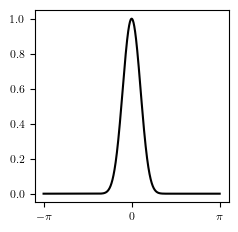

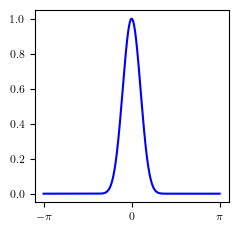

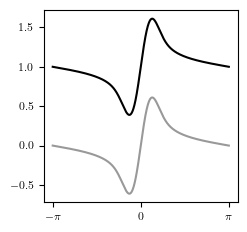

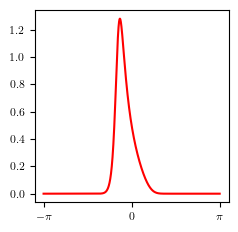

In [275]:
fig = plt.figure(figsize=(2.5, 2.5))
plt.plot(lmbda_circle.quad_pts, lmbda_circle.density_vals, color='k')
plt.gca().set_xticks([-np.pi, 0, np.pi])
plt.gca().set_xticklabels(["$-\pi$", "$0$", "$\pi$"])
plt.savefig(f"../figures/lambda_Q.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

fig = plt.figure(figsize=(2.5, 2.5))
plt.plot(lmbda_circle.quad_pts, lmbda_circle.density_vals, color='blue')
plt.gca().set_xticks([-np.pi, 0, np.pi])
plt.gca().set_xticklabels(["$-\pi$", "$0$", "$\pi$"])
plt.savefig(f"../figures/lambda_Q_blue.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

sigma = 1
from src.hilbert_transform import HilbertTransform
Hlmbda = HilbertTransform(lmbda_circle)
fig = plt.figure(figsize=(2.5, 2.5))
plt.plot(lmbda_circle.quad_pts, Hlmbda(lmbda_circle.quad_pts), color='k', alpha=0.4)
plt.plot(lmbda_circle.quad_pts, Hlmbda(lmbda_circle.quad_pts) + sigma, color='k')
plt.gca().set_xticks([-np.pi, 0, np.pi])
plt.gca().set_xticklabels(["$-\pi$", "$0$", "$\pi$"])
plt.savefig(f"../figures/Hlambda+sigma_Q.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

fig = plt.figure(figsize=(2.5, 2.5))
plt.plot(mu_circle.quad_pts, mu_circle.density_vals, color='red')
plt.gca().set_xticks([-np.pi, 0, np.pi])
plt.gca().set_xticklabels(["$-\pi$", "$0$", "$\pi$"])
plt.savefig(f"../figures/mu_Q.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

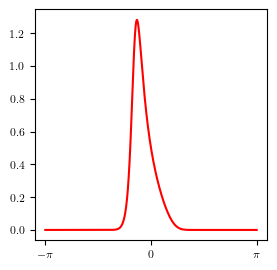

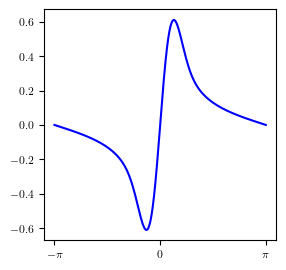

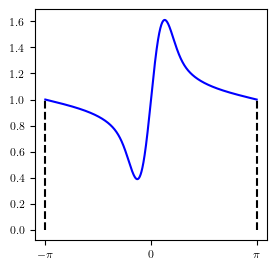

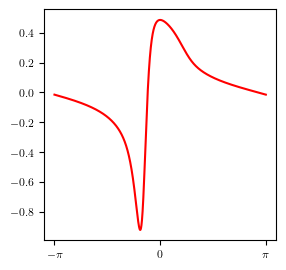

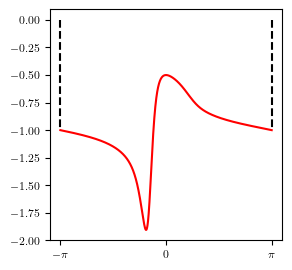

In [ ]:
from src.hilbert_transform import HilbertTransform
Hlmbda = HilbertTransform(lmbda_circle)
fig = plt.figure(figsize=(3, 3))
plt.plot(lmbda_circle.quad_pts, Hlmbda(lmbda_circle.quad_pts), color='blue')
plt.gca().set_xticks([-np.pi, 0, np.pi])
plt.gca().set_xticklabels(["$-\pi$", "$0$", "$\pi$"])
plt.savefig(f"../figures/Hlambda_Q.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

fig = plt.figure(figsize=(3, 3))
plt.plot(lmbda_circle.quad_pts, Hlmbda(lmbda_circle.quad_pts) + c0, color='blue')
plt.vlines(x=[-np.pi, np.pi], ymin=0, ymax=c0, color="k", linestyle="dashed")
plt.gca().set_xticks([-np.pi, 0, np.pi])
plt.gca().set_xticklabels(["$-\pi$", "$0$", "$\pi$"])
plt.savefig(f"../figures/Hlambda+c0_Q.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

Hmu = HilbertTransform(mu_circle)
fig = plt.figure(figsize=(3, 3))
plt.plot(mu_circle.quad_pts, Hmu(mu_circle.quad_pts), color='red')
plt.gca().set_xticks([-np.pi, 0, np.pi])
plt.gca().set_xticklabels(["$-\pi$", "$0$", "$\pi$"])
plt.savefig(f"../figures/Hmu_Q.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

fig = plt.figure(figsize=(3, 3))
plt.plot(mu_circle.quad_pts, Hmu(mu_circle.quad_pts) + zeta0, color='red')
plt.vlines(x=[-np.pi, np.pi], ymin=0, ymax=zeta0, color="k", linestyle="dashed")
plt.gca().set_xticks([-np.pi, 0, np.pi])
plt.gca().set_xticklabels(["$-\pi$", "$0$", "$\pi$"])
plt.savefig(f"../figures/Hmu+zeta0_Q.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

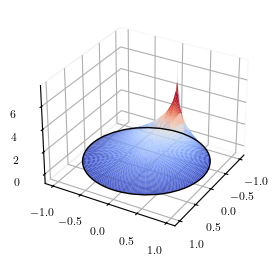

In [ ]:
density = None
atoms = np.array([-np.pi])
atom_wts = np.array([1])
quad_pts, quad_wts = fourier_quad(-np.pi, np.pi, int(1e4))
lmbda_circle = Distribution(density, atoms, atom_wts, quad_pts, quad_wts, periodic_domain=(-np.pi, np.pi))

thetas = np.linspace(-np.pi, np.pi, 10000)
rads = np.linspace(0, 1, 1000)
Thetas, Rads = np.meshgrid(thetas, rads)
Zs = Rads*np.exp(1j*Thetas)
zs = np.reshape(Zs, -1)

Q = (1 - Zs)/(1 + Zs)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(azim=azim, elev=elev)
vals = np.real(Q)
vals = np.sign(vals)*np.log(np.abs(vals)+1)
ax.plot_surface(np.real(Zs), np.imag(Zs), vals, cmap=cm.coolwarm)
circle = plt.Circle((0, 0), 1, color='black', fill=False)
p = ax.add_patch(circle)
art3d.pathpatch_2d_to_3d(p, z=0, zdir="z")
plt.savefig(f"../figures/ReQ_delta.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, projection='3d', computed_zorder=False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(azim=azim, elev=elev)
circle = plt.Circle((0, 0), 1, color='black', fill=False)
p = ax.add_patch(circle)
art3d.pathpatch_2d_to_3d(p, z=0, zdir="z")
vals = np.imag(Q)
vals = np.sign(vals)*np.log(np.abs(vals)+1)
ax.plot_surface(np.real(Zs), np.imag(Zs), vals, cmap=cm.coolwarm)
ax.set_zlim(-10, 10)
plt.savefig(f"../figures/ImQ_delta.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

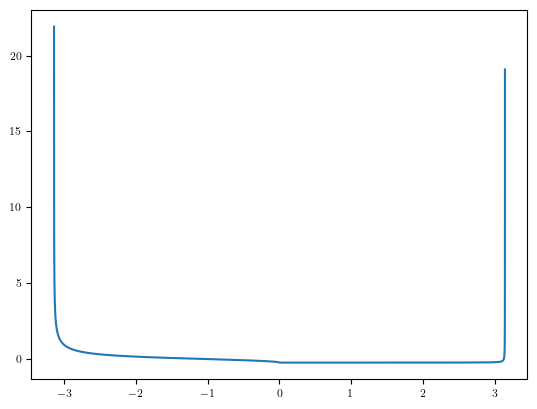

In [112]:
plt.plot(lmbda_circle.quad_pts, Hlmbda(lmbda_circle.quad_pts))
plt.show()

In [99]:
pol, res, zer, zj, fj, wj = aaa(lmbda.density_vals, lmbda.quad_pts, max_terms=100)

AAA failed to converge within 100 iterations.


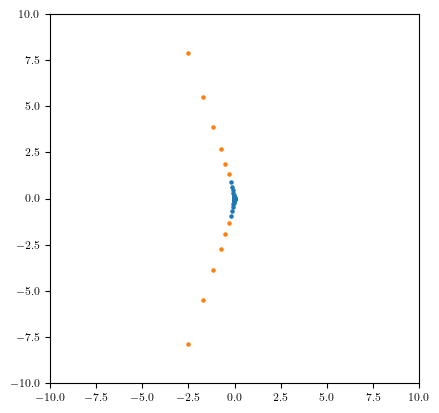

In [108]:
in_circle = np.abs(pol) < 1

fig, ax = plt.subplots()
ax.scatter(np.real(pol[in_circle]), np.imag(pol[in_circle]), marker='o', s=5)
ax.scatter(np.real(pol[~in_circle]), np.imag(pol[~in_circle]), marker='o', s=5)
#circle = plt.Circle((0, 0), 1, color='black', fill=False)
#ax.add_patch(circle)
ax.set_aspect('equal')
ax.set_ylim([-10, 10])
ax.set_xlim([-10, 10])
plt.show()

In [103]:
len(zer) - len(pol)

0

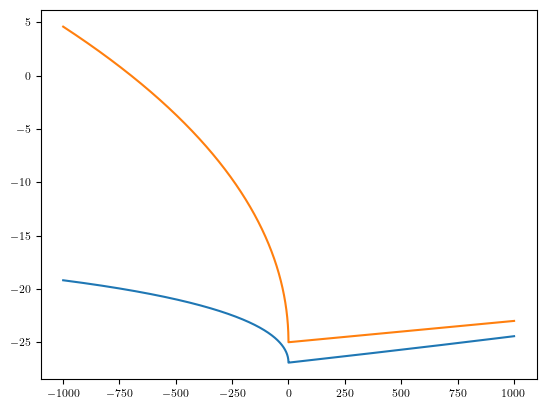

In [96]:
plt.plot(lmbda.quad_pts, Hlmbda(lmbda.quad_pts))
plt.plot(lmbda.quad_pts, -25 + lmbda.quad_pts/500 + np.sqrt(-lmbda.quad_pts * (lmbda.quad_pts < 0)))
#plt.plot(lmbda.quad_pts, 2/np.pi*1/np.sqrt(np.abs(lmbda.quad_pts))*np.log(np.abs(lmbda.quad_pts)))
plt.show()

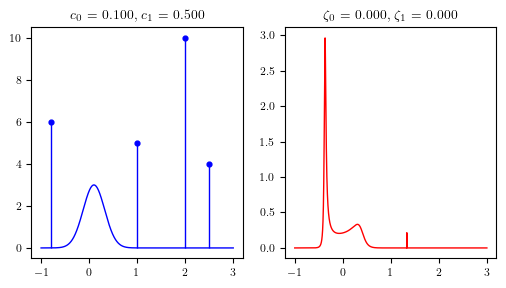

/Users/georgestepaniants/Research/time-deconvolution/experiments/../src/hilbert_transform.py:196: RuntimeWarning: divide by zero encountered in divide
  self.H_disc = lambda x: np.sum(self.lmbda.atom_wts[None, :] / np.tan((x[:, None] - self.lmbda.atoms[None, :])/2), axis=1)


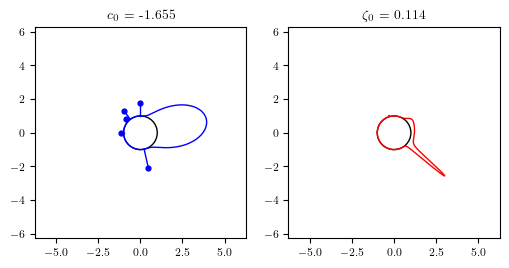

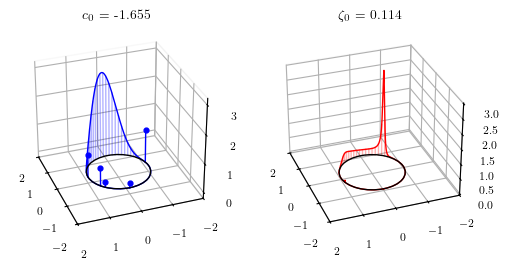

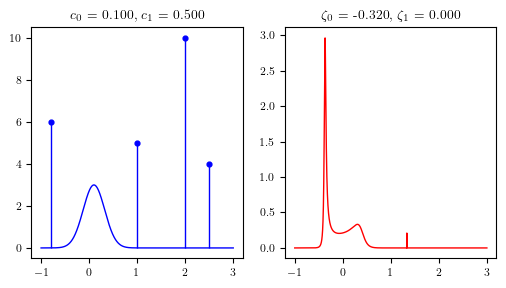

In [4]:
# Define lmbda on real line
quad_pts, quad_wts = trap_quad(-1, 3, 10000)
atoms = np.array([-0.8, 1, 2, 2.5])
atom_wts = 5*np.array([1.2, 1, 2, 0.8])
density = lambda x: (x+3 < 1) * (x+3 > -1)
density = lambda x: 3*np.exp(-10*(x-0.1)**2)
#density = None
lmbda_real = Distribution(density, atoms, atom_wts, quad_pts, quad_wts, periodic_domain=None, full_support=True)
c0_real = 0.1
c1_real = 0.5

# Invert lmbda on real line to obtain mu on real line
mu_real, zeta0_real, zeta1_real = B_real(lmbda_real, c0_real, c1_real)

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
plot_real_distribution(axs[0], lmbda_real, color="blue")
plot_real_distribution(axs[1], mu_real, color="red")
axs[0].set_title(f"$c_0$ = {c0_real:.3f}, $c_1$ = {c1_real:.3f}")
axs[1].set_title(f"$\zeta_0$ = {zeta0_real:.3f}, $\zeta_1$ = {zeta1_real:.3f}")
plt.show()



# Map (lmbda, c0) on real line to (lmbda, c0, c1) on circle
lmbda_circle, c0_circle = psi_real_to_circle(lmbda_real, c0_real, c1_real, len(quad_pts))

'''
# Map (lmbda, c0) on real line to (lmbda, c0, c1) on circle
mu2_circle, zeta02_circle = psi_real_to_circle(mu_real, zeta0_real, zeta1_real, 10)
fig, axs = plt.subplots(1, 1, figsize=(3, 3))
plot_circle_distribution(axs, mu2_circle, width = 2*np.pi, atom_scale = 1, density_scale = 1, color="red")
axs.set_title(f"$\zeta_0$ = {zeta02_circle:.3f}")
plt.show()
'''

# Invert lmbda on circle to obtain mu on circle
mu_circle, zeta0_circle = B_circle(lmbda_circle, c0_circle)

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
plot_circle_distribution(axs[0], lmbda_circle, width = 2*np.pi, color="blue")
plot_circle_distribution(axs[1], mu_circle, width = 2*np.pi, color="red")
axs[0].set_title(f"$c_0$ = {c0_circle:.3f}")
axs[1].set_title(f"$\zeta_0$ = {zeta0_circle:.3f}")
plt.show()

a = 0.01
rescale_func = lambda x: x #np.log((x + a)/a)

fig = plt.figure(figsize=(6, 3))
ax0 = fig.add_subplot(1, 2, 1, projection='3d')
ax0.xaxis.pane.fill = False
ax0.yaxis.pane.fill = False
ax0.zaxis.pane.fill = False
ax0.view_init(azim=160, elev=30)
ax1 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False
ax1.view_init(azim=160, elev=30)
plot_circle_distribution_3D(ax0, lmbda_circle, width = 2, color="blue")
plot_circle_distribution_3D(ax1, mu_circle, width = 2, density_scale=rescale_func, atom_scale=rescale_func, color="red")
ax0.set_title(f"$c_0$ = {c0_circle:.3f}")
ax1.set_title(f"$\zeta_0$ = {zeta0_circle:.3f}")
plt.show()

# Map lmbda on circle to real line and mu on circle to real line
lmbda_circle_to_real, c0_circle_to_real, c1_circle_to_real = psi_inv_circle_to_real(lmbda_circle, c0_circle, quad_pts)
mu_circle_to_real, zeta0_circle_to_real, zeta1_circle_to_real = psi_inv_circle_to_real(mu_circle, zeta0_circle, quad_pts)

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
plot_real_distribution(axs[0], lmbda_circle_to_real, color="blue")
plot_real_distribution(axs[1], mu_circle_to_real, color="red")
axs[0].set_title(f"$c_0$ = {c0_circle_to_real:.3f}, $c_1$ = {c1_circle_to_real:.3f}")
axs[1].set_title(f"$\zeta_0$ = {zeta0_circle_to_real:.3f}, $\zeta_1$ = {zeta1_circle_to_real:.3f}")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'figures/lambda_real_comm.pdf'

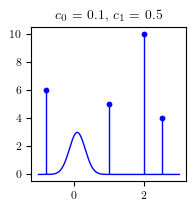

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
plot_real_distribution(ax, lmbda_real, color="blue", s=10)
ax.set_title(f"$c_0$ = {c0_real:.1f}, $c_1$ = {c1_real:.1f}")
plt.savefig(f"../figures/lambda_real_comm.pdf", bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(2, 2))
plot_real_distribution(ax, mu_real, color="red", s=10)
ax.set_title(f"$\zeta_0$ = {zeta0_real:.0f}, $\zeta_1$ = {zeta1_real:.0f}")
plt.savefig(f"../figures/mu_real_comm.pdf", bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(azim=160, elev=30)
xlim = ax.get_xlim3d()
ylim = ax.get_ylim3d()
zlim = ax.get_zlim3d()
plot_circle_distribution_3D(ax, lmbda_circle, width = 2, color="blue")
ax.set_title(f"$c_0$ = {c0_circle:.3f}")
ax.set_box_aspect((1, 1, 1))
plt.savefig(f"../figures/lambda_circle_comm.pdf", bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(azim=160, elev=30)
plot_circle_distribution_3D(ax, mu_circle, width = 2, density_scale=rescale_func, atom_scale=rescale_func, color="red")
ax.set_title(f"$\zeta_0$ = {zeta0_circle:.3f}")
ax.set_box_aspect((1, 1, 1))
plt.savefig(f"../figures/mu_circle_comm.pdf", bbox_inches='tight')
plt.show()

In [5]:
0.1 / np.diff(lmbda_circle.quad_pts)[0]

159.15494309186025

In [24]:
mu_circle.atoms - np.pi

array([-3.07495066e+00, -8.88178420e-16])

In [5]:
zeta1_real/zeta1_circle_to_real

0.0

In [13]:
sigma_int(lmbda_circle)

-0.5411268065124439

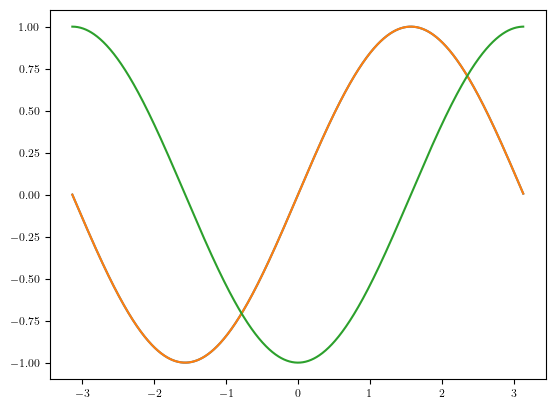

In [ ]:
xs, _ = fourier_quad(-np.pi, np.pi, 1000)
us = np.cos(1*xs) #np.exp(-3*xs**2)

H0 = fourier_hilbert_transform(us, xs)
H1 = continuous_periodic_hilbert_transform(us, xs, aaa_iters=1000, periodic_domain=(-np.pi, np.pi))
H2 = continuous_periodic_hilbert_transform_v2(us, xs, aaa_iters=1000, periodic_domain=(-np.pi, np.pi))
H3 = continuous_periodic_hilbert_transform_v3(us, xs, aaa_iters=1000, periodic_domain=(-np.pi, np.pi))
H4 = continuous_periodic_hilbert_transform_v4(us, xs, aaa_iters=1000, periodic_domain=(-np.pi, np.pi))
H5 = continuous_periodic_hilbert_transform_v5(us, xs, aaa_iters=1000, periodic_domain=(-np.pi, np.pi))

plt.plot(xs, H0(xs))
plt.plot(xs, H1(xs))
#plt.plot(xs, 2*H2(xs))
#plt.plot(xs, H3(xs))
#plt.plot(xs, H4(xs))
plt.plot(xs, H5(xs))
plt.show()

#ys = xs#, _ = fourier_quad(-np.pi, np.pi, 10000)
#plt.plot(ys, H1(ys))
#plt.plot(ys, H2(ys))
#plt.show()

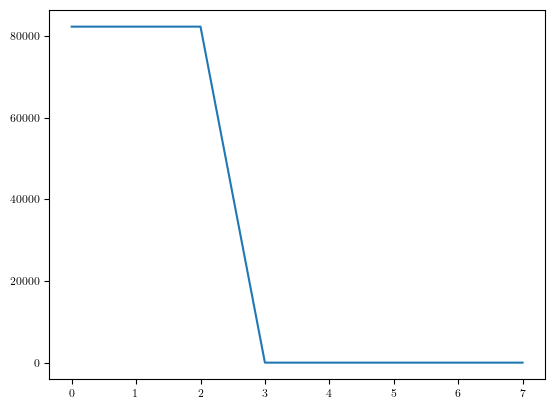

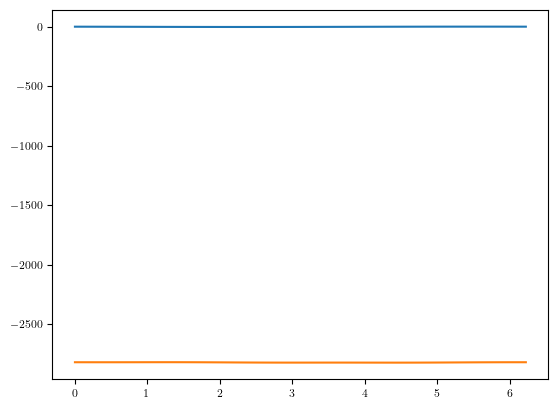

In [ ]:
periodic_domain = (-np.pi, np.pi)
zs = np.exp(2*np.pi*1j*(xs - periodic_domain[0])/(periodic_domain[1] - periodic_domain[0]))
pol, res, _, _, _, _ = aaa(us, zs, max_terms=100)

plt.plot(np.abs(pol))
plt.show()

in_circle = np.abs(pol) < 1
f = lambda x: (np.sum(res[in_circle] / (x[:, None] - pol[in_circle]), axis=1) - np.sum(res[~in_circle] / (x[:, None] - pol[~in_circle]), axis=1))/2
Hu = lambda x: -4*np.imag(f(np.exp(2*np.pi*1j*(x - periodic_domain[0])/(periodic_domain[1] - periodic_domain[0]))))


in_circle = np.abs(pol) < 1
f = lambda x: np.sum(res[in_circle] / (x[:, None] - pol[in_circle]), axis=1)
Hu = lambda x: -2*np.imag(f(np.exp(2*np.pi*1j*(x - periodic_domain[0])/(periodic_domain[1] - periodic_domain[0]))))

'''
in_circle = np.abs(pol) >= 1
f = lambda x: np.sum(res[in_circle] / (x[:, None] - pol[in_circle]), axis=1)
Hu = lambda x: np.imag(f(np.exp(2*np.pi*1j*(x - periodic_domain[0])/(periodic_domain[1] - periodic_domain[0]))))
'''

in_circle = np.abs(pol) < 1
f = lambda x: np.sum(res[in_circle] / (x[:, None] - 1/pol[in_circle]), axis=1)
Hu = lambda x: np.real(f(np.exp(2*np.pi*1j*(x - periodic_domain[0])/(periodic_domain[1] - periodic_domain[0]))))

plt.plot(xs, H0(xs))
plt.plot(xs, Hu(xs))
plt.show()

In [69]:
#us_hat = np.sum(res/(zs[:, None] - pol), axis=1)
def aaa_eval(zs, zj, fj, wj):
    with np.errstate(divide='ignore', invalid='ignore'):
        C = 1.0 / (zs[:,None] - zj[None,:])
        r = C.dot(wj*fj) / C.dot(wj)

    # for z in zj, the above produces NaN; we check for this
    nans = np.nonzero(np.isnan(r))[0]
    for i in nans:
        # is xv[i] one of our nodes?
        nodeidx = np.nonzero(zs[i] == zj)[0]
        if len(nodeidx) > 0:
            # then replace the NaN with the value at that node
            r[i] = fj[nodeidx[0]]
    return r

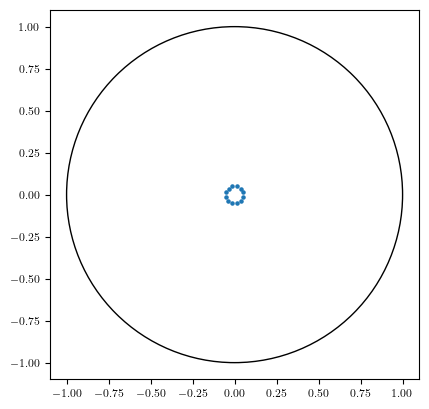

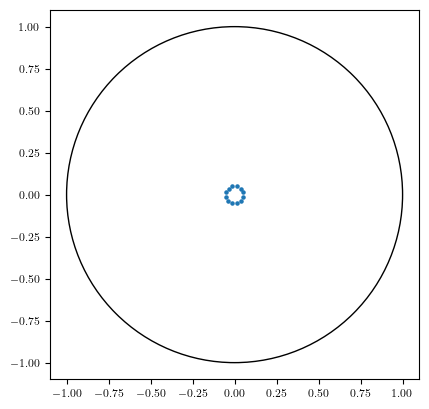

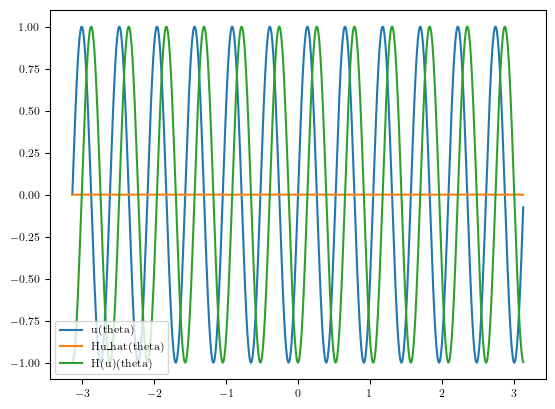

In [ ]:
xs = np.linspace(-np.pi, np.pi, 1000)[:-1]
zs = np.exp(1j*xs)
us = np.sin(12*xs) #np.cos(5*xs)
pol, _, _, _, _, _ = aaa(us, zs, max_terms=100)

fig, ax = plt.subplots()
ax.scatter(np.real(pol), np.imag(pol), marker='o', s=5)
circle = plt.Circle((0, 0), 1, color='black', fill=False)
ax.add_patch(circle)
ax.set_aspect('equal')
plt.show()

in_circle = np.abs(pol) < 1

fig, ax = plt.subplots()
ax.scatter(np.real(pol[in_circle]), np.imag(pol[in_circle]), marker='o', s=5)
circle = plt.Circle((0, 0), 1, color='black', fill=False)
ax.add_patch(circle)
ax.set_aspect('equal')
plt.show()

thresh = 1e-5
at_origin = np.abs(pol) < thresh
k = np.sum(at_origin)

new_pol = pol[~at_origin]

d = np.min(np.abs(new_pol[:, None] - zs), axis=1)
A = d / (zs[:, None] - new_pol)
A = np.column_stack((np.power(1/zs[:, None], np.arange(1, k+1)), A))
A = np.concatenate([np.real(A), -np.imag(A)], axis=1)
c = np.reshape(np.linalg.lstsq(A, us, rcond=None)[0], (-1, 2), order='F') @ np.array([1, 1j])

f = lambda x: np.sum((c[k:]*d) / (x[:, None] - pol), axis=1) + np.sum(c[:k]/np.power(x[:, None], np.arange(1, k+1)), axis=1)
Hu = lambda x: -np.imag(f(np.exp(1j*x)))

H1 = continuous_periodic_hilbert_transform(us, xs, aaa_iters=1000, periodic_domain=(-np.pi, np.pi))

H = fourier_hilbert_transform(us, xs)

plt.plot(xs, us, label="u(theta)")
plt.plot(xs, Hu(xs), label="Hu_hat(theta)")
plt.plot(xs, H(xs), label="H(u)(theta)")
plt.legend()
plt.show()

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import OrthogonalMatchingPursuit

In [21]:
xs = np.linspace(-np.pi, np.pi, 1000)[:-1]
n = len(xs)
zs = np.exp(1j*xs)
us = np.sin(12*xs) + np.cos(5*xs) + np.sin(200*xs)# + np.exp(-10*xs**2)
pol, res, zer, zj, fj, wj = aaa(us, zs, max_terms=500, rtol=1e-5)

In [17]:
len(zer) - len(pol)

0

AAA failed to converge within 100 iterations.


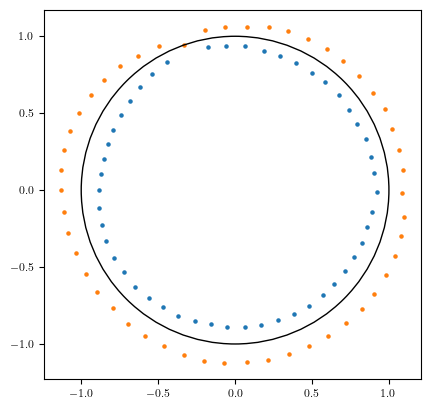

300
51047.48791985406
423466515.4553868
3512884713366.389
2.914128640403302e+16
2.4174279618418803e+20
2.0053877751553898e+24
1.6635780640505932e+28
1.3800283463759907e+32
1.1448084571180862e+36
9.496807851307866e+39
7.878117846168201e+43
6.535326582349091e+47
5.421408307408402e+51
4.4973526059155494e+55
3.7307982197718096e+59
3.0948997279742917e+63
2.567387395934056e+67
2.129787269429686e+71
1.7667742001882385e+75
1.4656351454700292e+79
1.2158239459281692e+83
1.0085919896648474e+87
8.366818280088352e+90
6.940730131644479e+94
5.757712567388142e+98
4.776335252902966e+102
3.962229475875426e+106
3.286884523014654e+110
2.7266492093435057e+114
2.2619035925225354e+118
1.876371864900868e+122
1.5565523601583308e+126
1.2912447128610478e+130
1.071157611634737e+134
8.885834091206109e+137
7.371281932631707e+141
6.114878667846864e+145
5.072623929490507e+149
4.208017023353324e+153
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf


/var/folders/pw/wkdn0vxs0b54swhpwjg6s0x00000gn/T/ipykernel_6749/3046978806.py:84: RuntimeWarning: overflow encountered in matmul
  prods = A_orig.conj().T @ res
/var/folders/pw/wkdn0vxs0b54swhpwjg6s0x00000gn/T/ipykernel_6749/3046978806.py:86: RuntimeWarning: overflow encountered in multiply
  res -= prods[ind] * A_orig[:, ind]
/var/folders/pw/wkdn0vxs0b54swhpwjg6s0x00000gn/T/ipykernel_6749/3046978806.py:86: RuntimeWarning: invalid value encountered in multiply
  res -= prods[ind] * A_orig[:, ind]


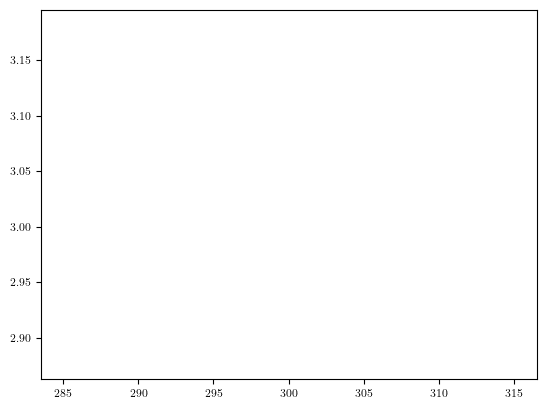

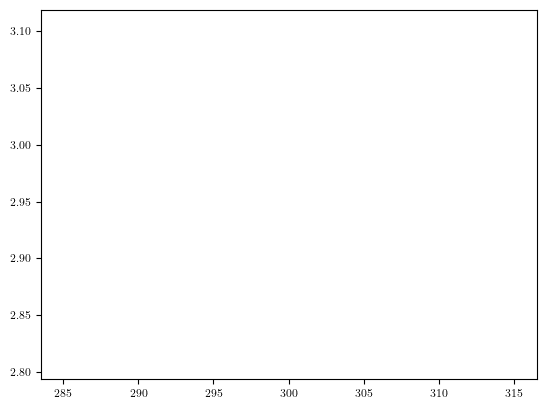

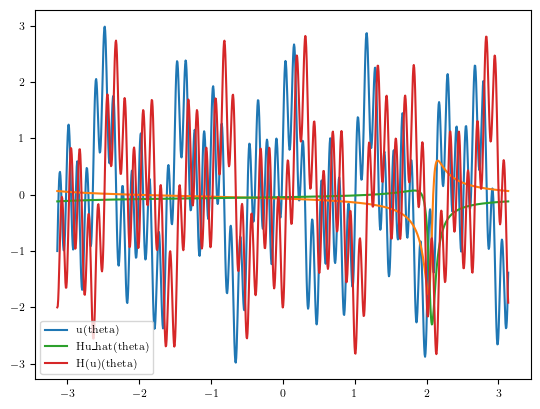

In [ ]:
xs = np.linspace(-np.pi, np.pi, 1000)[:-1]
n = len(xs)
zs = np.exp(1j*xs)
us = np.sin(12*xs) + np.cos(5*xs) + np.sin(50*xs)
pol, _, _, _, _, _ = aaa(us, zs, max_terms=100)

out_circle = np.abs(pol) > 1

fig, ax = plt.subplots()
ax.scatter(np.real(pol[~out_circle]), np.imag(pol[~out_circle]), marker='o', s=5)
ax.scatter(np.real(pol[out_circle]), np.imag(pol[out_circle]), marker='o', s=5)
circle = plt.Circle((0, 0), 1, color='black', fill=False)
ax.add_patch(circle)
ax.set_aspect('equal')
plt.show()

H = fourier_hilbert_transform(us, xs)

ks = np.arange(300, 301)
real_errs = np.zeros_like(ks, dtype=np.float64)
imag_errs = np.zeros_like(ks, dtype=np.float64)
conds = np.zeros_like(ks, dtype=np.float64)
for i in range(len(ks)):
    k = ks[i]
    print(k)
    
    if np.sum(out_circle) == 0 and k == 0:
        real_errs[i] = np.linalg.norm(us, ord=np.inf)
        imag_errs[i] = np.linalg.norm(H(xs), ord=np.inf)
        conds[i] = np.nan
    else:
        unit = np.ones((n, 1))
        poly = np.power(zs[:, None], np.arange(1, k+1))
        d = np.ones(np.sum(out_circle)) #np.min(np.abs(new_pol[:, None] - zs), axis=1)
        rational = d / (zs[:, None] - pol[out_circle])
        
        A_orig = np.column_stack((unit, poly, rational))
        #A = np.column_stack([np.real(A_orig), -np.imag(A_orig[:, 1:])])
        #print(np.linalg.cond(A))
        
        #c = np.linalg.lstsq(A, us, rcond=1e-15)[0]
        
        #clf = Lasso(alpha=1e-3, fit_intercept=False, max_iter=10000, tol=1e-15).fit(A, us)
        #c = clf.coef_
        
        '''
        fun = lambda c: A @ c - us
        jac = lambda _: A
        c_init = np.zeros(A.shape[1])
        c = scipy.optimize.least_squares(fun, c_init, jac=jac, method="lm").x
        '''
        
        '''
        AtA = A.T@A
        Atu = A.T@us
        fun = lambda c: np.sum((A @ c - us)**2)
        jac = lambda c: 2*(AtA@c - Atu)
        hess = lambda _: 2*AtA
        c_init = np.zeros(A.shape[1])
        c = scipy.optimize.minimize(fun, c_init, jac=jac, hess=hess, method="Nelder-Mead").x
        '''
        
        #c0 = c[0]
        #c = np.reshape(c[1:], (-1, 2), order='F') @ np.array([1, 1j])
        
        #f = lambda x: np.sum((c[k:]*d) / (x[:, None] - pol[out_circle]), axis=1) + np.sum(c[:k]*np.power(x[:, None], np.arange(1, k+1)), axis=1) + c0*np.ones_like(x)
        
        #eps = 1e-5
        #Q, R, P = scipy.linalg.qr(A_orig, pivoting=True)
        #r = np.diag(R)
        #P, L, U = scipy.linalg.lu(A_orig.T, permute_l=False, p_indices=True)
        #r = np.abs(np.diag(U))
        
        #keep_inds = np.zeros(A_orig.shape[1], dtype=bool)
        #keep_inds[P[np.abs(r) > np.abs(r[0])*eps]] = True
        
        tol = 1e-10
        max_iters = A_orig.shape[1]
        A_orig_nrm = A_orig / np.linalg.norm(A_orig, axis=0)
        cnt = 0
        res = us.astype(np.complex128)
        keep_inds = np.zeros(A_orig.shape[1], dtype=bool)
        while cnt < max_iters and np.linalg.norm(res) > tol:
            prods = A_orig.conj().T @ res
            ind = np.argmax(np.abs(prods))
            res -= prods[ind] * A_orig[:, ind]
            print(np.linalg.norm(res))
            keep_inds[ind] = True
            cnt += 1
        
        print(f"{np.sum(keep_inds)}/{A_orig.shape[1]}")
        unit_kept = keep_inds[0]
        poly_kept = keep_inds[1:k+1]
        rational_kept = keep_inds[k+1:]
        A_orig = A_orig[:, keep_inds]
        if unit_kept:
            A = np.column_stack([np.real(A_orig), -np.imag(A_orig[:, 1:])])
            print(np.linalg.cond(A))
            c = np.linalg.lstsq(A, us, rcond=1e-15)[0]
            c0 = c[0]
            c = np.reshape(c[1:], (-1, 2), order='F') @ np.array([1, 1j])
            c = np.insert(c, 0, c0)
        else:
            A = np.column_stack((np.real(A_orig), -np.imag(A_orig)))
            print(np.linalg.cond(A))
            c = np.linalg.lstsq(A, us, rcond=1e-15)[0]
            c = np.reshape(c, (-1, 2), order='F') @ np.array([1, 1j])
        c_unit = c[:np.sum(unit_kept)]
        c_poly = c[np.sum(unit_kept):np.sum(unit_kept)+np.sum(poly_kept)]
        c_rational = c[np.sum(unit_kept)+np.sum(poly_kept):]
        
        f = lambda x: np.sum(c_unit*x[:, None], axis=1) + np.sum(c_poly*np.power(x[:, None], np.arange(1, k+1)[poly_kept]), axis=1) + np.sum((c_rational*d[rational_kept]) / (x[:, None] - pol[out_circle][rational_kept]), axis=1)
        
        u = lambda x: np.real(f(np.exp(1j*x)))
        Hu = lambda x: np.imag(f(np.exp(1j*x)))
    
        real_errs[i] = np.linalg.norm(us - u(xs), ord=np.inf)
        imag_errs[i] = np.linalg.norm(H(xs) - Hu(xs), ord=np.inf)
        conds[i] = np.linalg.cond(A)

plt.plot(ks, real_errs)
plt.show()

plt.plot(ks, imag_errs)
plt.show()

plt.plot(xs, us, label="u(theta)")
plt.plot(xs, u(xs))
plt.plot(xs, Hu(xs), label="Hu_hat(theta)")
plt.plot(xs, H(xs), label="H(u)(theta)")
plt.legend()
plt.show()

AAA failed to converge within 100 iterations.


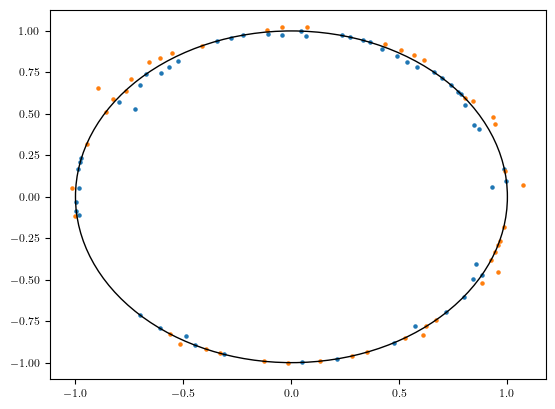

In [ ]:
xs = np.linspace(-np.pi, np.pi, 1000)[:-1]
n = len(xs)
zs = np.exp(1j*xs)
us = np.sin(12*xs) + np.cos(100*xs)# + np.exp(-100*xs**2)
pol, _, _, _, _, _ = aaa(us, zs, max_terms=100)

out_circle = np.abs(pol) > 1

fig, ax = plt.subplots()
ax.scatter(np.real(pol[~out_circle]), np.imag(pol[~out_circle]), marker='o', s=5)
ax.scatter(np.real(pol[out_circle]), np.imag(pol[out_circle]), marker='o', s=5)
circle = plt.Circle((0, 0), 1, color='black', fill=False)
ax.add_patch(circle)
#ax.set_aspect('equal')
plt.show()

H = fourier_hilbert_transform(us, xs)
Hus = H(xs)

/var/folders/pw/wkdn0vxs0b54swhpwjg6s0x00000gn/T/ipykernel_6749/2788214470.py:19: RuntimeWarning: divide by zero encountered in divide
  detinv = 1/(a_rere*a_imim - a_reim**2)


31.606961258558215
31.59484973611196
22.32842630402102
0.873156421338279
1.327554947734089
0.8731540383200287
0.8543165406882567
0.8536279293218481
0.8526032189783932
0.8515789348525242
0.8505551710659893
0.8495313651254142
0.8485075010929949
0.8474840811389087
0.8464595720938066
0.8454343130822244
0.8444082410711097
0.8433812017691601
0.8423542682194786
0.8413261226572099
0.8402974358598096
0.8392693142940539
0.8382407261381435
0.8372135116693572
0.83530375477054
0.8341574380532157
0.8330192185976667
0.8318831349035724
0.8307466646869862
0.8296109029820411
0.8284807145673558
0.8273495021743893
0.8262255252978493
0.8251035097405137
0.8239812463231404
0.8228590277461226
0.821744285172548
0.82063065188163
0.8195278398542896
0.8184314939430636
0.8173423427743086
0.8162533926282577
0.8151775515684963
0.8141037885776974
0.8130382323536586
0.811972714658047
0.8109060695336109
0.8098381351351214
0.8087688910220664
0.8076988059467679
0.8066300839001489
0.8055606246147877
0.8044904968476981
0.8

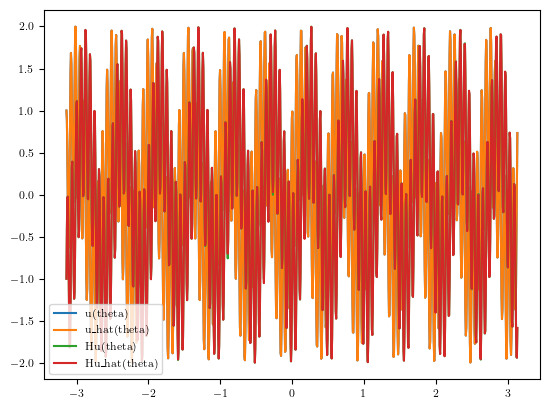

In [680]:
k = 201
poly = np.power(zs[:, None], np.arange(0, k+1))
rational = 1 / (zs[:, None] - pol[out_circle])

A = np.column_stack((poly, rational))

tol = 1e-15
max_iters = A.shape[1]
A_norms = np.linalg.norm(A, axis=0)
A_normalized = A / A_norms
A_re = np.real(A_normalized)
A_im = -np.imag(A_normalized)
a_rere = np.sum(A_re**2, axis=0)
a_reim = np.sum(A_re*A_im, axis=0)
a_imim = np.sum(A_im**2, axis=0)
cnt = 0
res = np.copy(us)
keep_inds = np.zeros(A.shape[1], dtype=bool)
detinv = 1/(a_rere*a_imim - a_reim**2)
detinv[~np.isfinite(detinv)] = 1

ws = np.zeros((0), dtype=np.complex128)
while cnt < max_iters and np.linalg.norm(res) > tol:
    print(np.linalg.norm(res))
    a_rere_nk = a_rere[~keep_inds]
    a_reim_nk = a_reim[~keep_inds]
    a_imim_nk = a_imim[~keep_inds]
    
    A_re_x = A_re[:, ~keep_inds].T @ res
    A_im_x = A_im[:, ~keep_inds].T @ res
    w_re = detinv[~keep_inds] * (a_imim_nk*A_re_x - a_reim_nk*A_im_x)
    w_im = detinv[~keep_inds] * (a_rere_nk*A_im_x - a_reim_nk*A_re_x)
    
    w_re[a_rere_nk == 0] = 0
    w_im[a_rere_nk == 0] = 1
    w_re[a_imim_nk == 0] = 1
    w_im[a_imim_nk == 0] = 0
    
    mags = np.sqrt(w_re**2 + w_im**2)
    max_ind = np.argmax(mags)
    w_re_max = w_re[max_ind]
    w_im_max = w_im[max_ind]
    ws = np.append(ws, w_re_max + 1j*w_im_max)
    ind = np.arange(A.shape[1])[~keep_inds][max_ind]
    
    res -= (w_re_max*A_re[:, ind] + w_im_max*A_im[:, ind])

    keep_inds[ind] = True
    cnt += 1
print(np.linalg.norm(res))

#keep_inds[k+1:] = True

A_sub_stacked = np.column_stack((A_re[:, keep_inds], A_im[:, keep_inds]))
ws = np.linalg.lstsq(A_sub_stacked, us, rcond=1e-15)[0]
ws = np.reshape(ws, (-1, 2), order='F') @ np.array([1, 1j])

inds = np.where(keep_inds)[0]

ws /= A_norms[keep_inds]

poly_kept = np.where(keep_inds[:k+1])[0]
poly_wts = ws[inds < k+1]
print(f"polynomials kept: {len(poly_kept)} / {k+1}")

rational_kept = np.where(keep_inds[k+1:])[0]
rational_wts = ws[inds >= k+1]
print(f"rationals kept: {len(rational_kept)} / {np.sum(out_circle)}")

f = lambda z: np.sum(poly_wts*np.power(z[:, None], np.arange(k+1)[poly_kept]), axis=1) + np.sum(rational_wts / (z[:, None] - pol[out_circle][rational_kept]), axis=1)

u = lambda x: np.real(f(np.exp(1j*x)))
Hu = lambda x: np.imag(f(np.exp(1j*x)))

u_err = np.linalg.norm(us - u(xs), ord=np.inf)
Hu_err = np.linalg.norm(Hus - Hu(xs), ord=np.inf)

print("u_err:", u_err)
print("Hu_err:", Hu_err)

plt.plot(xs, us, label="u(theta)")
plt.plot(xs, u(xs), label="u_hat(theta)")
plt.plot(xs, Hus, label="Hu(theta)")
plt.plot(xs, Hu(xs), label="Hu_hat(theta)")
plt.legend()
plt.show()

In [662]:
poly_wts.shape

(100,)

In [659]:
np.linalg.norm(res)

0.5182274322154755

In [558]:
rational_wts

array([ 0.44849676+0.70934524j,  0.35254289-0.4534281j ,
        0.05920899+0.22807655j, -0.24854521-0.14951868j,
        0.06232699-0.18731165j,  0.12563423+0.23753141j,
        0.03601007-0.14275379j, -0.16590748+0.09733064j,
        0.03928467+0.05722981j, -0.01282594-0.0760851j ,
        0.00677606+0.06318357j,  0.03807669-0.00491243j])

In [568]:
cnt

12

In [550]:
pol[out_circle].shape

(15,)

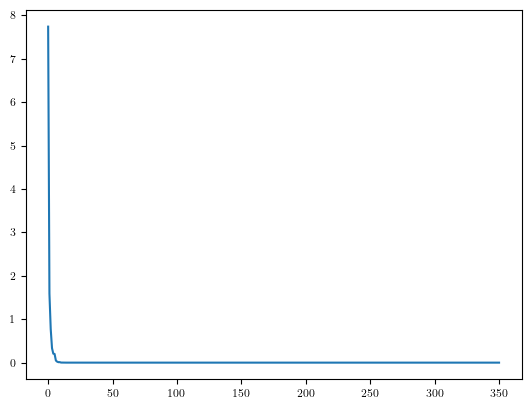

In [347]:
plt.plot(np.abs(np.diag(U)))
plt.show()

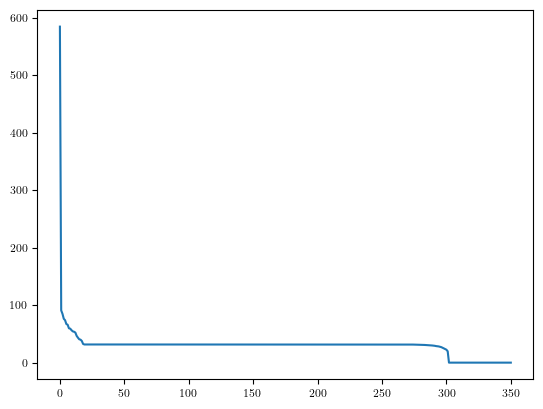

In [ ]:
plt.plot(np.abs(r))
plt.show()

In [329]:
poly_kept

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [288]:
c_unit

array([], dtype=float64)

In [272]:
Q, R, P = scipy.linalg.qr(A, mode="economic", pivoting=True)

In [335]:
P[np.abs(r) <= np.abs(r[0])*eps]

array([ 13, 314, 305, 307,  15, 308,   7, 310, 313, 338, 316, 311, 336,
       344,  10,   5,  12,  14, 341,   2, 333,  11, 329,   9, 346, 335,
       330, 326, 350, 317, 324, 320,   8, 327, 339, 348, 319,   3,   6,
       347, 322, 345,   4,   1,   0], dtype=int32)

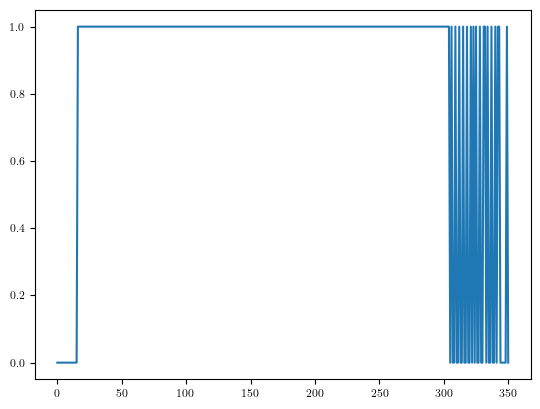

In [ ]:
plt.plot(keep_inds)
plt.show()

In [338]:
A[:, P[:10]]

array([[ 3.79640508e-15,  5.02105188e-15,  5.38105243e-02, ...,
        -1.95943488e-15, -4.65365784e-15,  7.22541611e-15],
       [ 1.93740751e-01,  2.55020076e-01,  5.25692412e-02, ...,
        -1.00461838e-01, -2.36731210e-01,  3.62621214e-01],
       [ 3.80139798e-01,  4.93176062e-01,  5.15199595e-02, ...,
        -1.99907185e-01, -4.60004337e-01,  6.75879973e-01],
       ...,
       [-5.52133646e-01, -6.98719062e-01,  5.88271457e-02, ...,
         2.97329837e-01,  6.57126385e-01, -8.97133376e-01],
       [-3.80139798e-01, -4.93176062e-01,  5.69243646e-02, ...,
         1.99907185e-01,  4.60004337e-01, -6.75879973e-01],
       [-1.93740751e-01, -2.55020076e-01,  5.52573756e-02, ...,
         1.00461838e-01,  2.36731210e-01, -3.62621214e-01]])

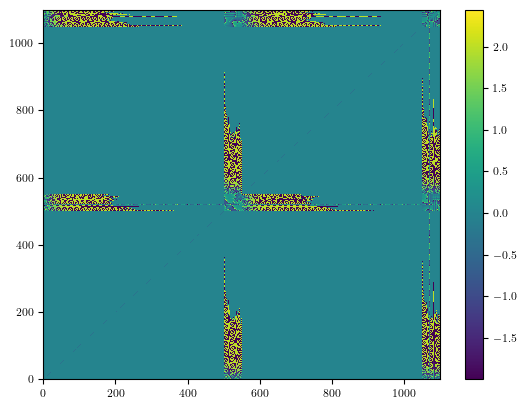

In [ ]:
M = A.T @ A / A.shape[1]
M = M * (np.abs(M) > 1e-10)
plt.pcolormesh(np.sign(M)*np.log10(np.abs(M) + 0.01))
plt.colorbar()
plt.show()

In [130]:
A = d / (zs[:, None] - pol[out_circle])
A = np.column_stack((np.power(zs[:, None], np.arange(k)), A))
A = np.concatenate([np.real(A), -np.imag(A)], axis=1)

In [141]:
np.linalg.norm(A[:, 499])

0.0

In [138]:
np.linalg.norm((A @ A.T)/k - np.eye(999))/np.sqrt(999)

0.054845419572760776

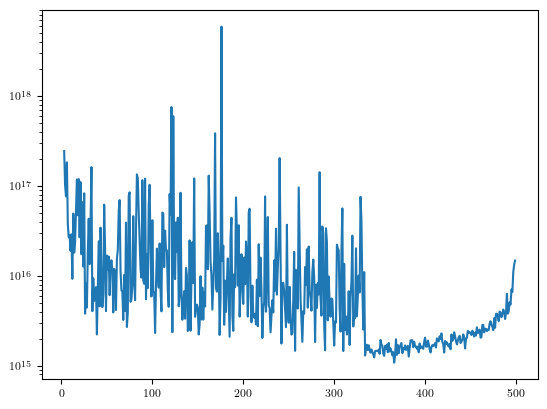

In [126]:
plt.plot(ks, conds)
plt.yscale("log")
plt.show()

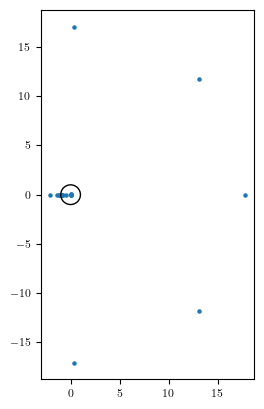

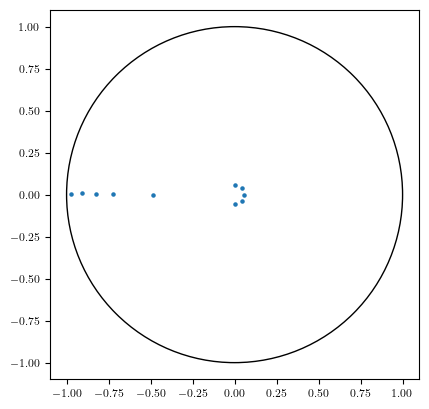

[ 3.52520145e-01-1.70708117e+01j  3.35364418e-01+1.70798823e+01j
  1.30140964e+01-1.17837365e+01j  1.30037467e+01+1.17983099e+01j
  1.76961245e+01+8.24897298e-03j -2.05716843e+00-4.91597700e-03j
  1.20917731e-03-5.85545169e-02j  4.22229314e-02-3.82311739e-02j
  5.65095080e-02+2.63136814e-05j  4.21792208e-02+3.82691944e-02j
  1.14919202e-03+5.85258465e-02j -1.38103517e+00+5.15663672e-03j
 -4.86101934e-01-1.16146429e-03j -1.21131192e+00+7.86212852e-03j
 -7.24085149e-01+2.70334531e-03j -8.25517796e-01+5.35756877e-03j
 -1.10172208e+00+8.32728470e-03j -9.07619844e-01+6.85969457e-03j
 -9.72049362e-01+6.63899023e-03j -1.02870819e+00+7.02616454e-03j]
[ 3.96035299e+02-5.77024819e+02j  3.91521510e+02+5.80092651e+02j
 -1.17387697e+03-4.37758574e+03j -1.20241663e+03+4.36735003e+03j
 -7.87844863e+03-2.44485602e+01j  1.34473017e-05+1.00414007e-07j
  1.27557059e+00+2.03365281e+00j -1.37559188e+01-5.19575186e+00j
  2.51585886e+01-5.45643890e-02j -1.37210736e+01+5.25553941e+00j
  1.26253040e+00-2.03887

In [43]:
fig, ax = plt.subplots()
ax.scatter(np.real(pol), np.imag(pol), marker='o', s=5)
circle = plt.Circle((0, 0), 1, color='black', fill=False)
ax.add_patch(circle)
ax.set_aspect('equal')
plt.show()

circle_inds = np.abs(pol) < 1
fig, ax = plt.subplots()
ax.scatter(np.real(pol[circle_inds]), np.imag(pol[circle_inds]), marker='o', s=5)
circle = plt.Circle((0, 0), 1, color='black', fill=False)
ax.add_patch(circle)
ax.set_aspect('equal')
plt.show()

print(pol)
print(res)

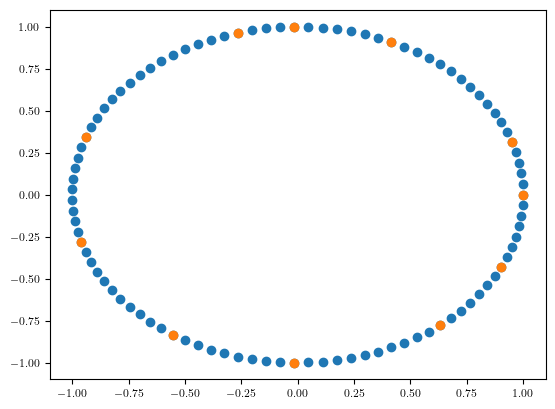

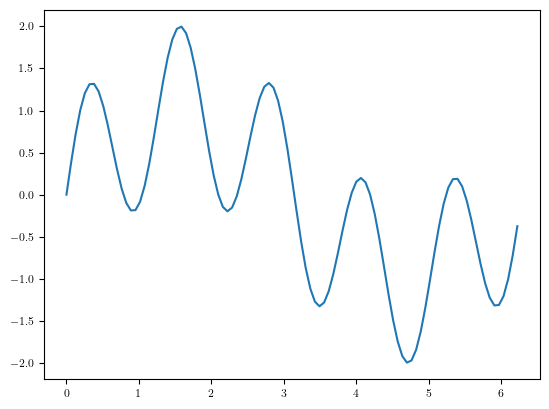

IndexError: boolean index did not match indexed array along dimension 0; dimension is 5 but corresponding boolean dimension is 8

In [ ]:
plt.scatter(np.real(zs), np.imag(zs))
plt.show()

plt.plot(xs, us)
plt.show()

plt.plot(xs, Hu(xs))
plt.plot(xs, H2(xs))
plt.show()

no roots to left or right


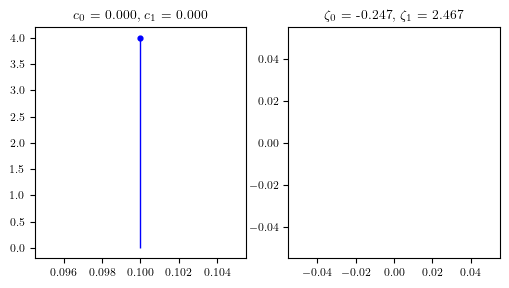

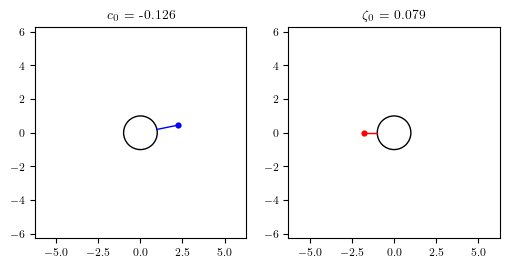

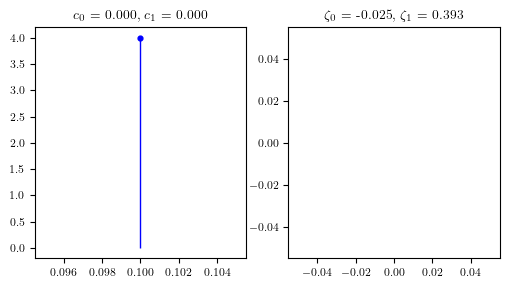

In [681]:
# Define lmbda on real line
quad_pts, quad_wts = trap_quad(-10, 10, 100)
atoms = np.array([0.1])
atom_wts = np.array([4])
lmbda_real = Distribution(None, atoms, atom_wts, quad_pts, quad_wts, periodic_domain=None)
c0_real = 0
c1_real = 0

# Invert lmbda on real line to obtain mu on real line
mu_real, zeta0_real, zeta1_real = B_real(lmbda_real, c0_real, c1_real)

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
plot_real_distribution(axs[0], lmbda_real, color="blue")
plot_real_distribution(axs[1], mu_real, color="red")
axs[0].set_title(f"$c_0$ = {c0_real:.3f}, $c_1$ = {c1_real:.3f}")
axs[1].set_title(f"$\zeta_0$ = {zeta0_real:.3f}, $\zeta_1$ = {zeta1_real:.3f}")
plt.show()

# Map (lmbda, c0) on real line to (lmbda, c0, c1) on circle
lmbda_circle, c0_circle = psi_real_to_circle(lmbda_real, c0_real, c1_real, 10)

# Invert lmbda on circle to obtain mu on circle
mu_circle, zeta0_circle = B_circle(lmbda_circle, c0_circle)

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
plot_circle_distribution(axs[0], lmbda_circle, width = 2*np.pi, atom_scale = 1, density_scale = 1, color="blue")
plot_circle_distribution(axs[1], mu_circle, width = 2*np.pi, atom_scale = 1, density_scale = 1, color="red")
axs[0].set_title(f"$c_0$ = {c0_circle:.3f}")
axs[1].set_title(f"$\zeta_0$ = {zeta0_circle:.3f}")
plt.show()

# Map lmbda on circle to real line and mu on circle to real line
lmbda_circle_to_real, c0_circle_to_real, c1_circle_to_real = psi_inv_circle_to_real(lmbda_circle, c0_circle, quad_pts, quad_wts)
mu_circle_to_real, zeta0_circle_to_real, zeta1_circle_to_real = psi_inv_circle_to_real(mu_circle, zeta0_circle, quad_pts, quad_wts)

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
plot_real_distribution(axs[0], lmbda_circle_to_real, color="blue")
plot_real_distribution(axs[1], mu_circle_to_real, color="red")
axs[0].set_title(f"$c_0$ = {c0_circle_to_real:.3f}, $c_1$ = {c1_circle_to_real:.3f}")
axs[1].set_title(f"$\zeta_0$ = {zeta0_circle_to_real:.3f}, $\zeta_1$ = {zeta1_circle_to_real:.3f}")
plt.show()

In [87]:
mu_circle.atoms[0] == -np.pi

True

/Users/georgestepaniants/Research/time-deconvolution/hilbert_transform.py:95: RuntimeWarning: divide by zero encountered in divide
  self.H_disc = lambda x: 1/math.pi*np.sum(self.lmbda.atom_wts[None, :] / (x[:, None] - self.lmbda.atoms[None, :]), axis=1)


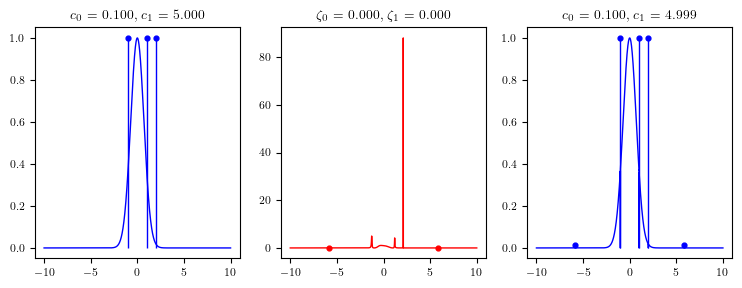

In [114]:
n = 100001
quad_pts, quad_wts = trap_quad(-10, 10, n)
density = lambda x: np.exp(-x**2) #np.ones_like(x)

lmbda_real = Distribution(density, np.array([-1, 1, 2]), np.array([1, 1, 1]), quad_pts, quad_wts)
c0_real = 0.1
c1_real = 5

mu_real, zeta0_real, zeta1_real = B_real(lmbda_real, c0_real, c1_real)

lmbda_real_hat, c0_real_hat, c1_real_hat = B_real(mu_real, zeta0_real, zeta1_real)

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
plot_real_distribution(axs[0], lmbda_real, color="blue")
plot_real_distribution(axs[1], mu_real, color="red")
plot_real_distribution(axs[2], lmbda_real_hat, color="blue")
axs[0].set_title(f"$c_0$ = {c0_real:.3f}, $c_1$ = {c1_real:.3f}")
axs[1].set_title(f"$\zeta_0$ = {zeta0_real:.3f}, $\zeta_1$ = {zeta1_real:.3f}")
axs[2].set_title(f"$c_0$ = {c0_real_hat:.3f}, $c_1$ = {c1_real_hat:.3f}")
plt.show()

In [113]:
mu_real.zero_sets

array([[   -inf, -5.8768],
       [-5.8768, -5.5024],
       [-1.0002, -0.9998],
       [ 0.9998,  1.0002],
       [ 1.9998,  2.0002],
       [ 2.9998,  3.0002],
       [ 5.504 ,  5.8768],
       [ 5.8768,     inf]])

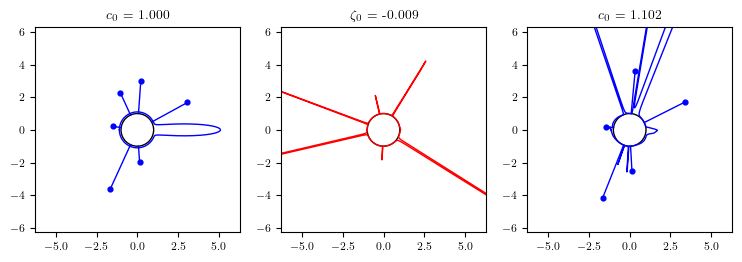

In [15]:
n = 1001
quad_pts, quad_wts = fourier_quad(-np.pi, np.pi, n)

sigma = 0.1
density = lambda theta: 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-theta**2/(2*sigma**2)) + 0.1
#density = lambda theta: np.exp(-theta**2)
#density = lambda theta: 1*(np.abs(theta) < 0.6)
#density = lambda theta: np.ones_like(theta)

atoms = np.array([])
atom_wts = np.array([])

atoms = np.array([-2, -1.5, 0.5, 1.5, 2, 3])
atom_wts = np.array([3, 1, 2.5, 2, 1.5, 0.5])

lmbda_circle = Distribution(density, atoms, atom_wts, quad_pts, quad_wts, periodic_domain=(-np.pi, np.pi))
c0_circle = 1
mu_circle, zeta0_circle = B_circle(lmbda_circle, c0_circle, thresh=1e-5)

lmbda_circle_hat, c0_circle_hat = B_circle(mu_circle, zeta0_circle)
new_pts = (quad_pts[1:] + quad_pts[:-1])/2
new_wts = quad_wts[1:]
lmbda_circle_hat.update_quadrature(new_pts, new_wts)

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
plot_circle_distribution(axs[0], lmbda_circle, width = 2*np.pi, atom_scale = 1, density_scale = 1, color="blue")
plot_circle_distribution(axs[1], mu_circle, width = 2*np.pi, atom_scale = 1, density_scale = 1, color="red")
plot_circle_distribution(axs[2], lmbda_circle_hat, width = 2*np.pi, atom_scale = 1, density_scale = 1, color="blue")
axs[0].set_title(f"$c_0$ = {c0_circle:.3f}")
axs[1].set_title(f"$\zeta_0$ = {zeta0_circle:.3f}")
axs[2].set_title(f"$c_0$ = {c0_circle_hat:.3f}")
plt.show()

In [5]:
1/mu_circle.offset_moments(atoms, -2)

array([3. , 1. , 2.5, 2. , 1.5, 0.5])

In [105]:
mu_circle.zero_sets

array([[3.1409644 , 3.14159265],
       [3.14159265, 3.14159265]])

In [91]:
lmbda_circle.atoms

array([-2. , -1.5,  0.5,  1.5,  2. ,  3. ])

In [22]:
np.max(lmbda_circle_hat.density_vals)

2.0077123926152134

In [ ]:
np.min(mu_circle.density(new_pts))

1.2960583252001054e-08

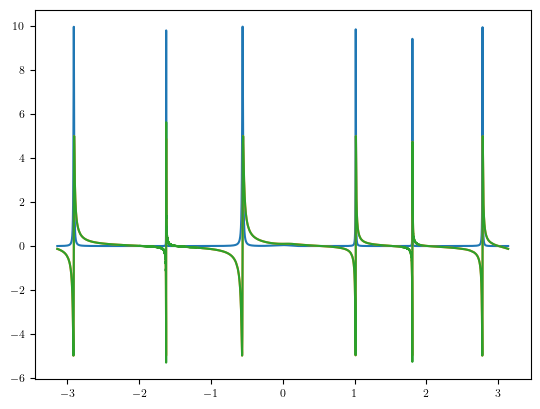

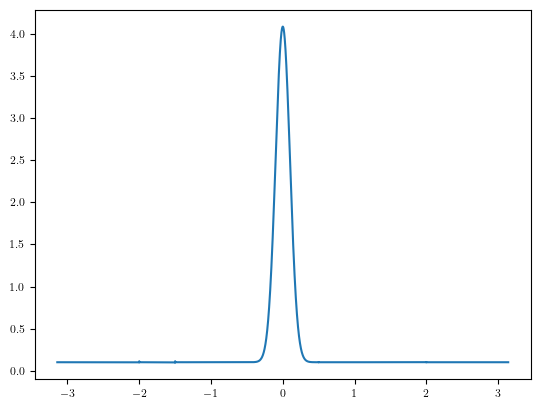

In [ ]:
H = HilbertTransform(mu_circle)

plt.plot(quad_pts, mu_circle.density_vals)
plt.plot(quad_pts, H(quad_pts))
plt.plot(quad_pts, np.imag(scipy.signal.hilbert(mu_circle.density_vals)))
#plt.plot(quad_pts, scipy.special.dawsn(quad_pts/(2*sigma))*np.sqrt(sigma/2))
for i in range(mu_circle.zero_sets.shape[0]):
    plt.plot([mu_circle.zero_sets[i, 0], mu_circle.zero_sets[i, 1]], [0, 0], color="black", linewidth=5)
plt.show()

new_pts = quad_pts[1:]*1/4 + quad_pts[:-1]*3/4

plt.plot(new_pts, mu_circle.density(new_pts)/(mu_circle.density(new_pts)**2 + (H(new_pts) + zeta0_circle)**2))
plt.show()

In [4]:
lmbda_circle.moment(0)

6.276908398780808

In [40]:
quad_pts, quad_wts = trap_quad(-np.pi, -np.pi+2*np.pi*(n-1)/n, n)
quad_pts1, quad_wts1 = fourier_quad(-np.pi, np.pi, n)

In [3]:
mu_circle.density_vals

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

In [18]:
mu_circle.moment(0)

0.7169568003235303

In [19]:
lmbda_circle.moment(0) / (lmbda_circle.moment(0)**2 + c0_circle**2)

0.9900990099009901

In [4]:
H = HilbertTransform(lmbda_circle)

In [34]:
lmbda_circle.zero_sets

array([[-3.14159265,  3.14159265]])

In [29]:
mu_circle.atoms

array([], dtype=float64)

In [17]:
lmbda_circle.zero_sets == np.pi

array([[False, False]])

In [89]:
print(lmbda_circle.atoms)
print(lmbda_circle_hat.atoms)

print(lmbda_circle.atom_wts)
print(lmbda_circle_hat.atom_wts)

[-2.  -1.5  0.5  1.5  2.   3. ]
[]
[3.  1.  2.5 2.  1.5 0.5]
[]


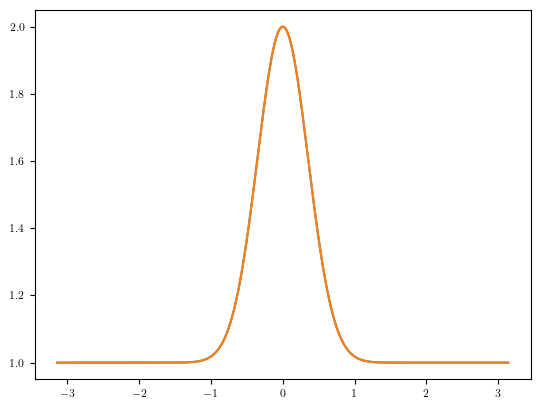

In [88]:
plt.plot(quad_pts, lmbda_circle.density(quad_pts))
plt.plot(quad_pts, lmbda_circle_hat.density(quad_pts))
plt.show()

In [ ]:
np.imag(1/(mu_circle.moment(0) + 1j*zeta0_circle))

In [ ]:
np.imag(1/(2*math.pi + 1j))

In [ ]:
lmbda_circle.moment(0)

In [4]:
H = HilbertTransform(lmbda_circle)

In [ ]:
lmbda_circle.zero_sets

In [ ]:
print(lmbda_circle.atoms)
print(lmbda_circle_hat.atoms)

In [ ]:
mu_circle, zeta0_circle = B_circle(lmbda_circle, c0_circle)

In [ ]:
lmbda.zero_sets

In [ ]:
zeta0_circle != 0 or mu_circle.num_atoms > 0# or (mu_circle.density is not None)

In [94]:
H = lambda x: 1/(2*math.pi) * np.sum(lmbda_circle.atom_wts[None, :] / np.tan((x[:, None] - lmbda_circle.atoms[None, :])/2), axis=1)

In [ ]:
quad_pts == np.pi/2

In [96]:
inds = np.isfinite(H(quad_pts))

In [ ]:
H(quad_pts)

In [ ]:
np.isfinite(H(quad_pts))

In [99]:
inds = np.isfinite(H(quad_pts))

In [ ]:
lmbda_circle.zero_sets

In [ ]:
#H = HilbertTransform(lmbda_circle)

inds = np.isfinite(H(quad_pts))

plt.plot(quad_pts[inds], H(quad_pts[inds]))
plt.show()

In [ ]:
mu_circle.atom_wts

In [4]:
lmbda_real.zero_sets
Hlmbda = HilbertTransform(lmbda_real)

In [ ]:
plt.plot(quad_pts, Hlmbda(quad_pts))
plt.show()

In [ ]:
lmbda_real.atoms

In [ ]:
lmbda_real.zero_sets

In [ ]:
atom_scale = 1
density_scale = 1
width = 2*np.pi

fig, axs = plt.subplots(1, 2, figsize=(6, 3))

circle = plt.Circle((0, 0), 1, color='black', fill=False)
if lmbda.density is not None:
    axs[0].plot((density_scale*lmbda.density_vals+1)*np.cos(lmbda.quad_pts), (density_scale*lmbda.density_vals+1)*np.sin(lmbda.quad_pts), color="blue")
for i in range(lmbda.num_atoms):
    axs[0].plot(np.array([1, atom_scale*lmbda.atom_wts[i]+1])*np.cos(lmbda.atoms[i]), np.array([1, atom_scale*lmbda.atom_wts[i]+1])*np.sin(lmbda.atoms[i]), color="blue")
    axs[0].scatter((atom_scale*lmbda.atom_wts[i]+1)*np.cos(lmbda.atoms[i]), (atom_scale*lmbda.atom_wts[i]+1)*np.sin(lmbda.atoms[i]), color="blue")
axs[0].add_patch(circle)
axs[0].set_xlim(-width, width)
axs[0].set_ylim(-width, width)
axs[0].set_aspect('equal')
axs[0].legend()

In [ ]:
mu, zeta0 = B_circle(lmbda, 0.5)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

atom_scale = 1
density_scale = 1
width = 2*np.pi

circle = plt.Circle((0, 0), 1, color='black', fill=False)
if lmbda.density is not None:
    axs[0].plot((density_scale*lmbda.density_vals+1)*np.cos(lmbda.quad_pts), (density_scale*lmbda.density_vals+1)*np.sin(lmbda.quad_pts), color="blue")
for i in range(lmbda.num_atoms):
    axs[0].plot(np.array([1, atom_scale*lmbda.atom_wts[i]+1])*np.cos(lmbda.atoms[i]), np.array([1, atom_scale*lmbda.atom_wts[i]+1])*np.sin(lmbda.atoms[i]), color="blue")
    axs[0].scatter((atom_scale*lmbda.atom_wts[i]+1)*np.cos(lmbda.atoms[i]), (atom_scale*lmbda.atom_wts[i]+1)*np.sin(lmbda.atoms[i]), color="blue")
axs[0].add_patch(circle)
axs[0].set_xlim(-width, width)
axs[0].set_ylim(-width, width)
axs[0].set_aspect('equal')
axs[0].legend()

circle = plt.Circle((0, 0), 1, color='black', fill=False)
if mu.density is not None:
    axs[1].plot((density_scale*mu.density_vals+1)*np.cos(mu.quad_pts), (density_scale*mu.density_vals+1)*np.sin(mu.quad_pts), color="red")
for i in range(mu.num_atoms):
    axs[1].plot(np.array([1, atom_scale*mu.atom_wts[i]+1])*np.cos(mu.atoms[i]), np.array([1, atom_scale*mu.atom_wts[i]+1])*np.sin(mu.atoms[i]), color="red")
    axs[1].scatter((atom_scale*mu.atom_wts[i]+1)*np.cos(mu.atoms[i]), (atom_scale*mu.atom_wts[i]+1)*np.sin(mu.atoms[i]), color="red")
axs[1].add_patch(circle)
axs[1].set_xlim(-width, width)
axs[1].set_ylim(-width, width)
axs[1].set_aspect('equal')
axs[1].legend()

In [ ]:
plt.plot(lmbda.quad_pts, lmbda.density_vals)
plt.plot(lmbda.quad_pts, fourier_hilbert_transform(lmbda.density_vals, lmbda.quad_pts)(lmbda.quad_pts))
plt.show()

In [ ]:
#plt.plot(lmbda.quad_pts, lmbda.density_vals)
plt.plot(lmbda.quad_pts, Hlmbda(lmbda.quad_pts))
plt.show()

In [ ]:
thetas = 0.9*np.linspace(-math.pi, math.pi, 100)
xs = mobius(thetas)
thetas_hat = mobius_inv(xs)

plt.plot(thetas, xs)
plt.plot(thetas_hat, xs)
plt.show()

In [ ]:
i = -1
c = 1

def func(x):
    return Hlmbda(x) - c

per = lmbda.periodic_domain[1] - lmbda.periodic_domain[0]
func_per = lambda x: func((x - lmbda.periodic_domain[0]) % per)
interval = np.array([lmbda.zero_sets[i, 0]-lmbda.periodic_domain[0], per + lmbda.zero_sets[i, 1]-lmbda.periodic_domain[0]])
root = rescale_rootfind(func_per, interval)

In [ ]:
xs = np.linspace(interval[0], interval[1], 100)
plt.plot(xs, func_per(xs))
plt.scatter(root, func_per(root))
plt.show()

In [ ]:
lmbda.zero_sets

In [ ]:
Hlmbda.roots(c=1)

In [ ]:
plt.plot(lmbda.quad_pts, lmbda.density_vals)
plt.plot(lmbda.quad_pts, Hlmbda(lmbda.quad_pts))
plt.show()

In [ ]:
n = 10
#quad_pts, quad_wts = trap_quad(0, 2*np.pi*(n-1)/n, n)
quad_pts, quad_wts = trap_quad(0, 5*(n-1)/n, n)
sigma = 0.01
density = lambda x: 1/np.sqrt(2*sigma**2)*np.exp(-(x-np.pi)**2/(2*sigma))
atoms = np.array([0, 1, 2])
atom_wts = np.array([1, 2.3, 0.5])
lmbda = Distribution(density, atoms, atom_wts, quad_pts, quad_wts)

assert(np.allclose(np.diff(quad_pts), quad_pts[1] - quad_pts[0]))

thetas = 2*np.pi/5*np.fft.rfftfreq(n)*n
wts = np.fft.rfft(lmbda.density_vals)/n
Hu = 2*np.imag(np.exp(1j*quad_pts[:, None]*thetas)@wts)
Hup = np.imag(scipy.signal.hilbert(lmbda.density_vals))

plt.plot(quad_pts, density(quad_pts))
plt.plot(quad_pts, Hu)
#plt.plot(quad_pts, 1/(2*np.pi)/np.tan((quad_pts - np.pi)/2))
plt.plot(quad_pts, Hup)
plt.show()

In [62]:
n = 10
quad_pts, quad_wts = trap_quad(0, 5*(n-1)/n, n)

In [ ]:
(quad_pts[-1] - quad_pts[0]) * n/(n-1)

In [ ]:
thetas

In [ ]:
quad_pts

In [ ]:
n = 6
#halfpt = int(n/2) if n % 2 == 0 else int((n+1)/2)
#np.fft.rfftfreq(n)*n - np.fft.fftfreq(n)[:halfpt]*n

print(np.fft.fftfreq(n))
print(np.fft.rfftfreq(n))

In [ ]:
np.fft.fft([1, 2, 3, 4, 5])

In [ ]:
np.fft.rfft([1, 2, 3, 4, 5])

In [ ]:
print(np.linalg.norm(Hu - Hup, np.inf))

In [ ]:
plt.plot(thetas, np.real(wts))
plt.plot(thetas, np.imag(wts))
plt.show()

In [ ]:
~np.logical_xor(*np.isfinite((1, np.infty)))

In [ ]:
n = 10001
quad_pts, quad_wts = trap_quad(0, 2*np.pi*(n-1)/n, n)
sigma = 1
density = lambda x: 1/np.sqrt(2*sigma**2)*np.exp(-(x-np.pi)**2/(2*sigma))
atoms = np.array([0, 1, 2], dtype=np.float64)
atom_wts = np.array([1, 2.3, 0.5])
lmbda = Distribution(density, atoms, atom_wts, quad_pts, quad_wts, periodic_domain=(0, 2*np.pi))

In [ ]:
lmbda.zero_sets

In [ ]:
quad_pts, quad_wts = trap_quad(-10, 30, 2000)
density_1 = None
atoms_1 = np.array([5, 7, 8.1, 10.3, 12.2, 15])
atom_wts_1 = np.array([1, 2.3, 0.5, 0.7, 2, 0.4])
lmbda_1 = Distribution(None, atoms_1, atom_wts_1, quad_pts, quad_wts)

In [ ]:
lmbda_1.density_vals

In [ ]:
pts = np.concatenate(([-np.inf, -np.inf], [], [np.inf, np.inf]))
vals = np.concatenate(([1, 0], [], [0, 1]))
start_inds = np.where(np.diff((vals == 0).astype(int)) == 1)[0]
end_inds = np.where(np.diff((vals == 0).astype(int)) == -1)[0]+1

In [ ]:
start_inds

In [ ]:
end_inds

In [ ]:
pts